In [1]:
# Simulation imports
from reporting import simulation
from reporting.simulation import NORTH, EAST, SOUTH, WEST
from reporting.plot_outbreak import plot_outbreak

In [2]:
# Library imports
import geopandas
import matplotlib
import shapely
from matplotlib import pyplot




# Day 1
## All the field reports have come in and it's time to analyse them

In [4]:
simulation.gather_reports_for_day_1()

### Let's grab the data directly from the database

In [5]:
from psycopg2 import connect
connection = connect(dbname='johnsnow')
cases = geopandas.read_postgis(
    "select * from reporting_report", connection,
    geom_col='location',
    crs={'init': 'epsg:4326'}
)


In [7]:
cases[['doctor_name', 'patient_name', 'diagnosis', 'location']].sample(5)

,doctor_name,patient_name,diagnosis,location
21,Timothy Mason,Margaret Larson,typhoid,POINT (-0.08570511006185499 51.5341994949738)
7,Elizabeth Haubert,Karin Deitz,rubella,POINT (-0.1228081222392893 51.52233786954973)
49,Lola Gagnon,Joyce Lambert,rubella,POINT (-0.1096492012742355 51.49703656814182)
15,Bruce Junior,Jeffrey Stoughton,smallpox,POINT (-0.1219296514989345 51.52209235592687)
26,Clarence Walker,Bernadette Jones,typhoid,POINT (-0.08777037399489904 51.5328403977613)


### Now it's time to visualise them

In [8]:
# Set default size
matplotlib.rcParams['figure.figsize'] = [16.0, 12.0]

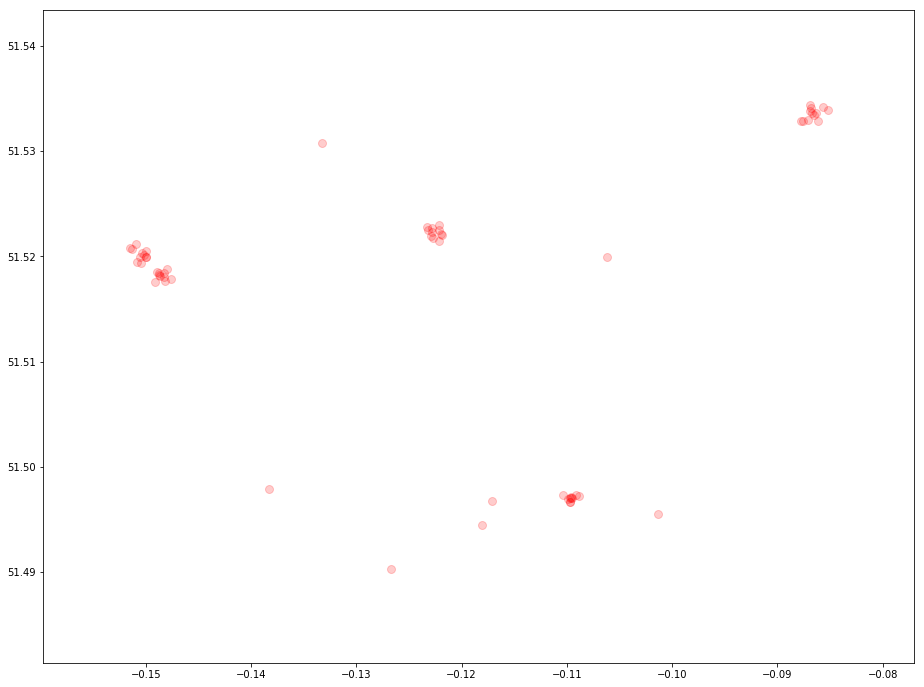

In [9]:
plot = cases.plot(marker="o", color="red", markersize=64, alpha=0.2)

### Let's distinguish different diagnoses

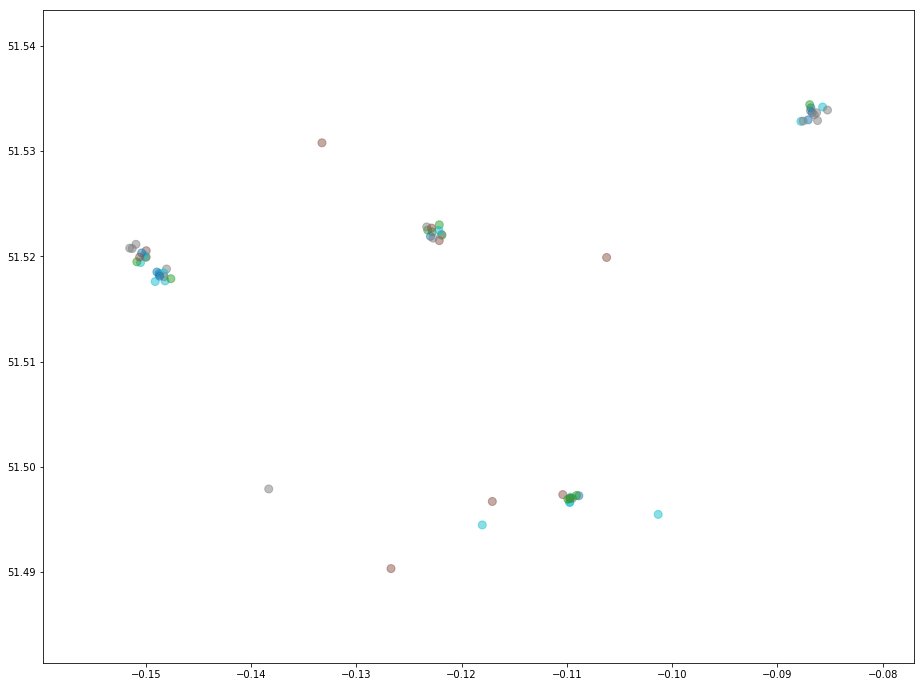

In [10]:
plot = cases.plot(marker="o", markersize=64, alpha=0.5, column='diagnosis')

### This data is useless without context. Let's map it

In [11]:
# Import London's rivers
rivers = geopandas.read_file('../open-street-map-data/london-rivers_shp/')

In [12]:
# Import London's roads
roads = geopandas.read_file('../open-street-map-data/london-roads_shp/')
# Filter the roads to just the most important ones
mains = roads[roads['highway'].isin(('trunk', 'primary', 'secondary', 'tertiary'))]

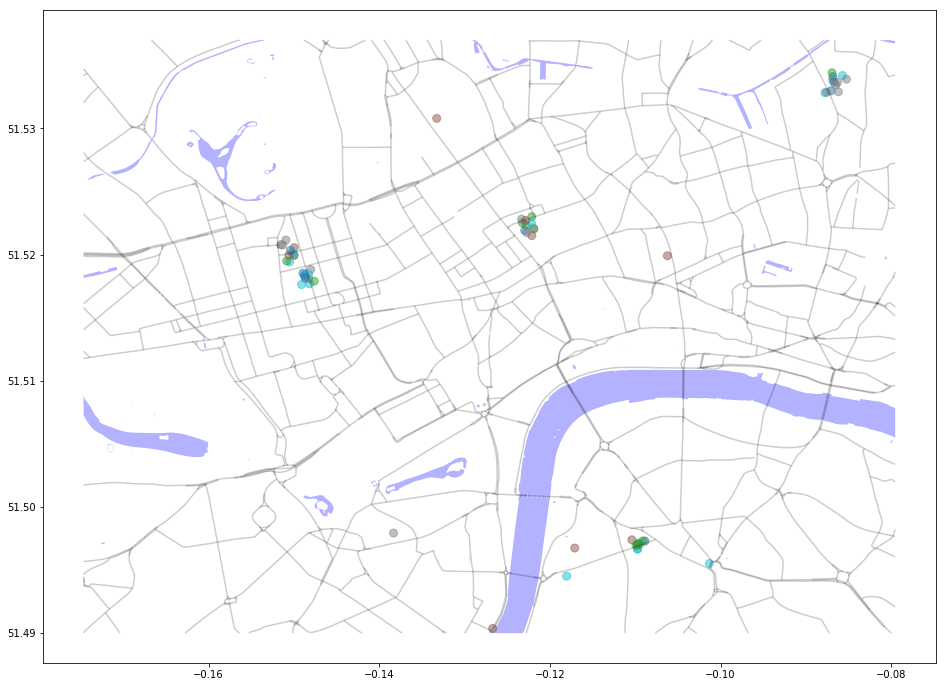

In [13]:
# Draw everything together
figure, axis = pyplot.subplots()
rivers_plot = rivers.plot(ax=axis, color='blue', alpha=0.3)
map_plot = mains.plot(ax=rivers_plot, color="black", alpha=0.2)
cases_plot = cases.plot(ax=map_plot, marker="o", column="diagnosis", markersize=64, alpha=0.5)

pyplot.show()

### What's going on? I have a hunch...

In [14]:
# Let's get open street map data about medical facilities
medical = geopandas.read_file('../open-street-map-data/london-medical_shp/')

# And use pandas filtering to select only the hospitals
hospitals = medical[medical['amenity'] == 'hospital'].copy()

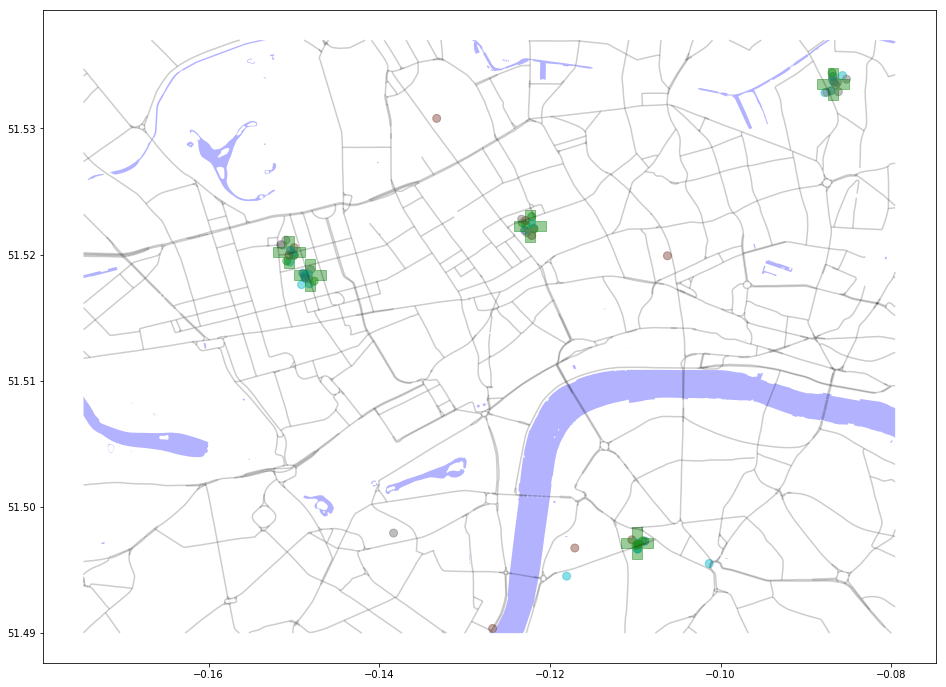

In [15]:
# Overlay our various geo-datasets
figure, axis = pyplot.subplots()
rivers_plot = rivers.plot(ax=axis, color='blue', alpha=0.3)
map_plot = mains.plot(ax=rivers_plot, color="black", alpha=0.2)
cases_plot = cases.plot(ax=map_plot, marker="o", column="diagnosis", markersize=64, alpha=0.5)

# Plot a green cross at the location of each hospital
final = hospitals.plot(ax=cases_plot, marker="P", markersize=1000, color="green", alpha=0.4)

pyplot.show()

### We need to improve our analysis

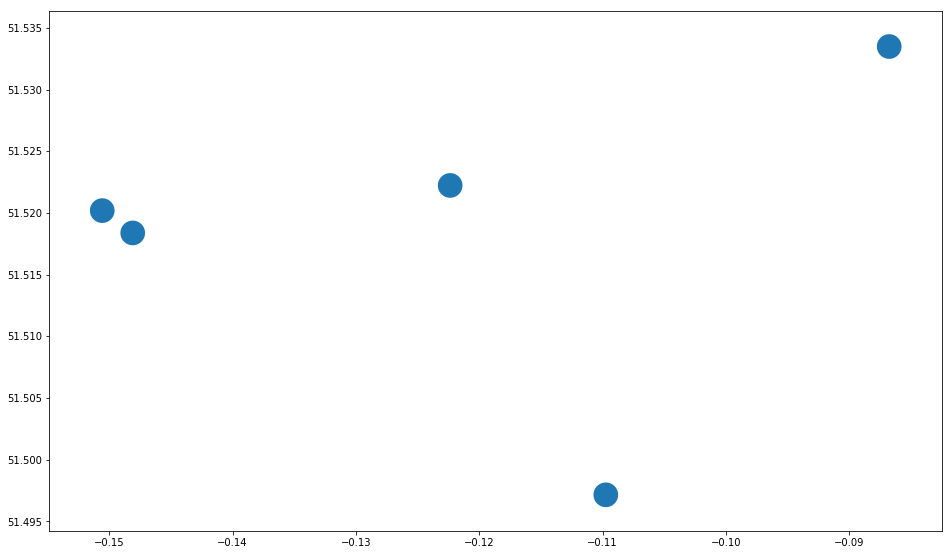

In [16]:
# Create a polygon representing about 100m around each hospital
hospitals['geometry'] = hospitals['geometry'].buffer(0.001)
hospitals.plot()

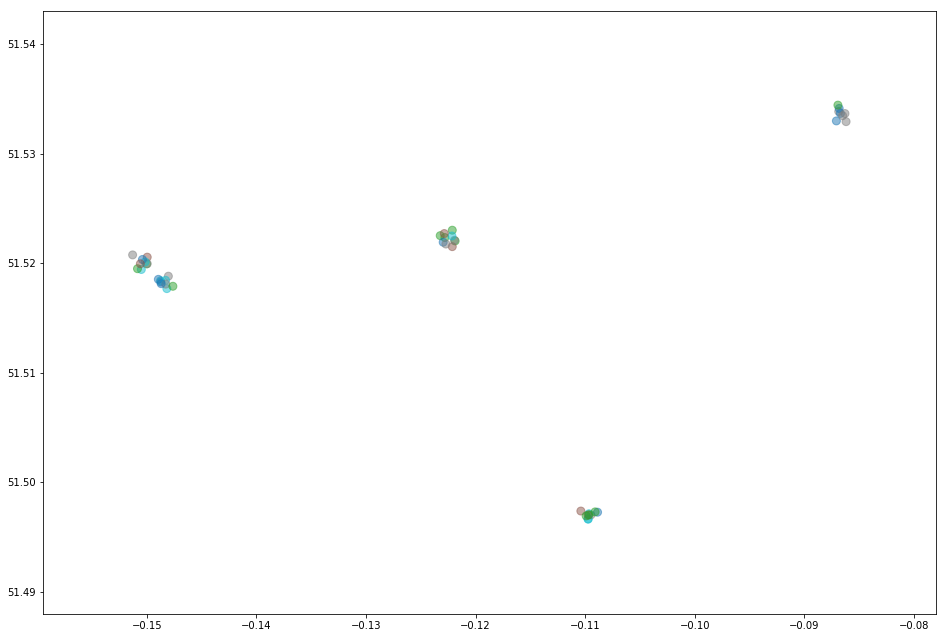

In [17]:
# Join together the hospital zones with the cases
# The "join" is a spatial one - we are joining cases with the hospitals that they are close to
hospital_cases = geopandas.sjoin(
    cases,
    hospitals,
    op='within'
)
hospital_cases.plot(marker="o", column="diagnosis", markersize=64, alpha=0.5)

In [19]:
# Now each case that happened in a hospital is associated with the relevant hospital.
hospital_cases[['doctor_name', 'patient_name', 'diagnosis', 'location', 'name']].sample(1)

,doctor_name,patient_name,diagnosis,location,name
19,Sue Pickett,Ryan Mikolajczyk,smallpox,POINT (-0.0868588521362425 51.53384391252553),The Hoxton Surgery


### Let's narrow down to cases that didn't happen at hospitals

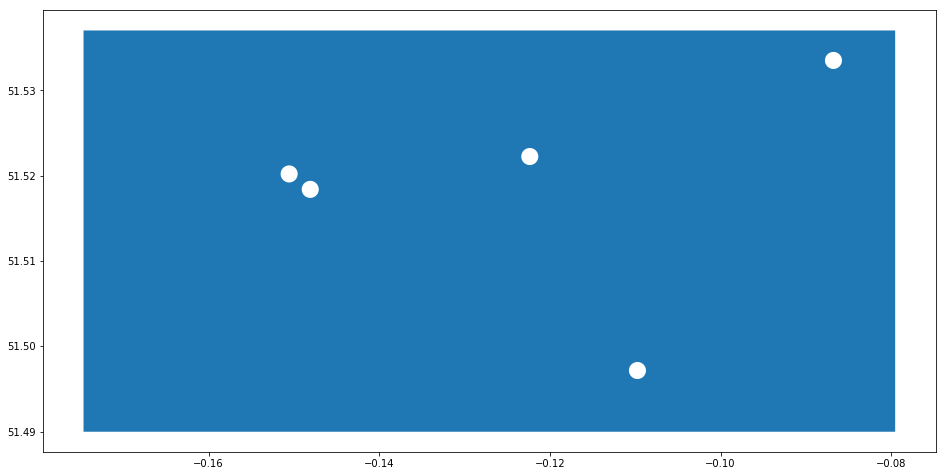

In [20]:
# This is a polygon representing the whole area under study
bounding_box = shapely.geometry.Polygon((
    (WEST, NORTH),
    (EAST, NORTH),
    (EAST, SOUTH),
    (WEST, SOUTH),
    (WEST, NORTH)
))

# This is an area with holes in for each hospital zone
# It will look like a slice of Swiss cheese
minus_hospital_zones = bounding_box.difference(hospitals.unary_union)

area_of_interest = geopandas.GeoDataFrame(
    {
        'geometry': [minus_hospital_zones],
        'name': ['Area of interest']
    },
    crs={'init': 'epsg:4326'}
)
area_of_interest.plot()

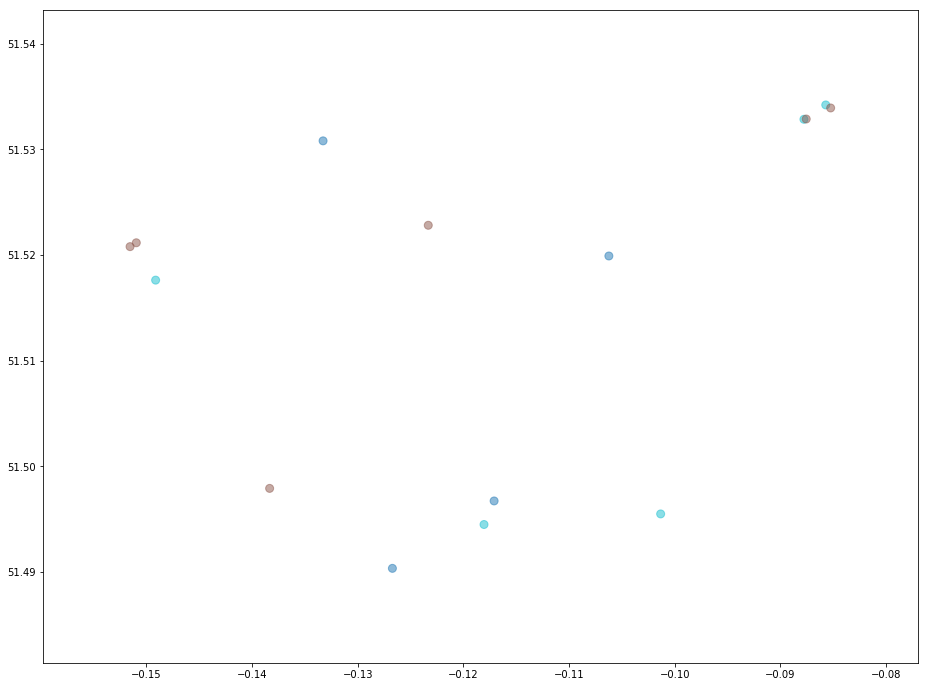

In [21]:
# Now we do another spatial join saying
non_hospital_cases = geopandas.sjoin(cases, area_of_interest, op='within')
non_hospital_cases.plot(marker="o", column="diagnosis", markersize=64, alpha=0.5)

### And let's pull everything together

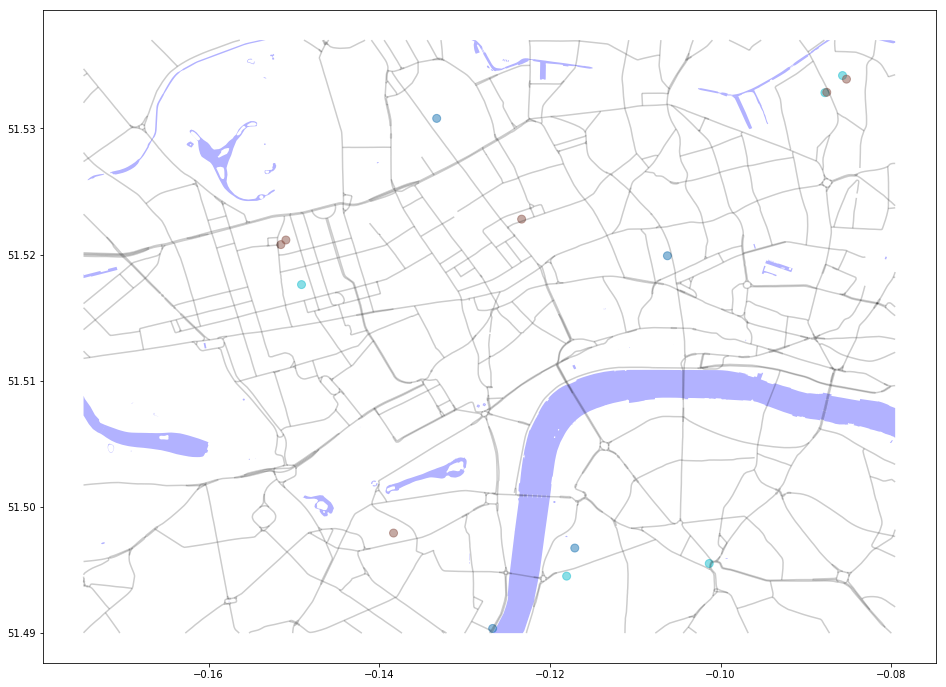

In [24]:
plot_outbreak()

# Day 2
### Not so peaceful

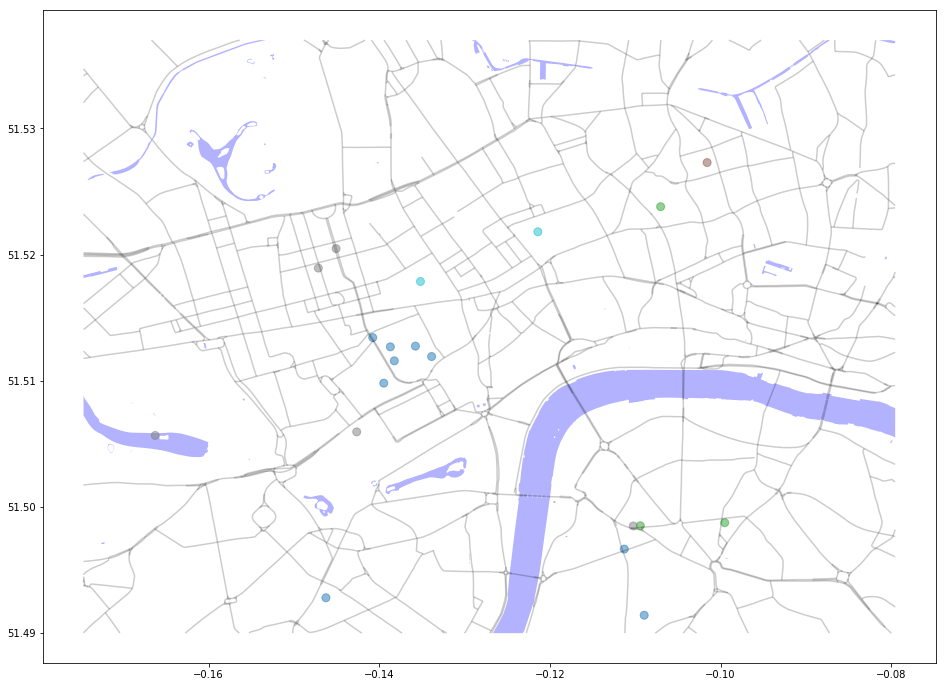

In [25]:
simulation.gather_reports_for_day_2()
plot_outbreak()

# Day 3

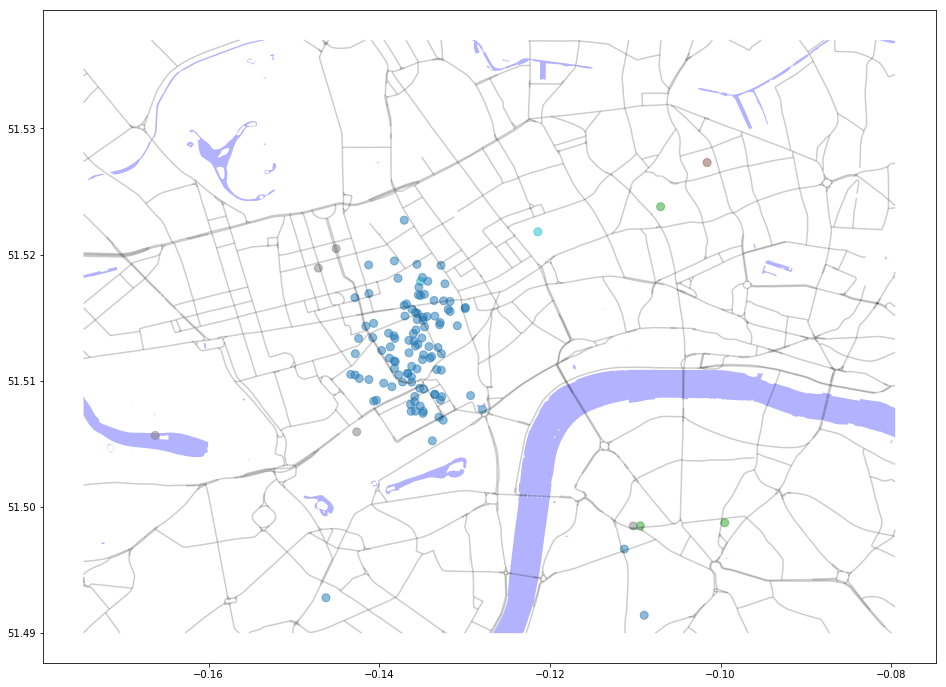

In [26]:
simulation.gather_reports_for_day_3()
plot_outbreak()

# 28 days later

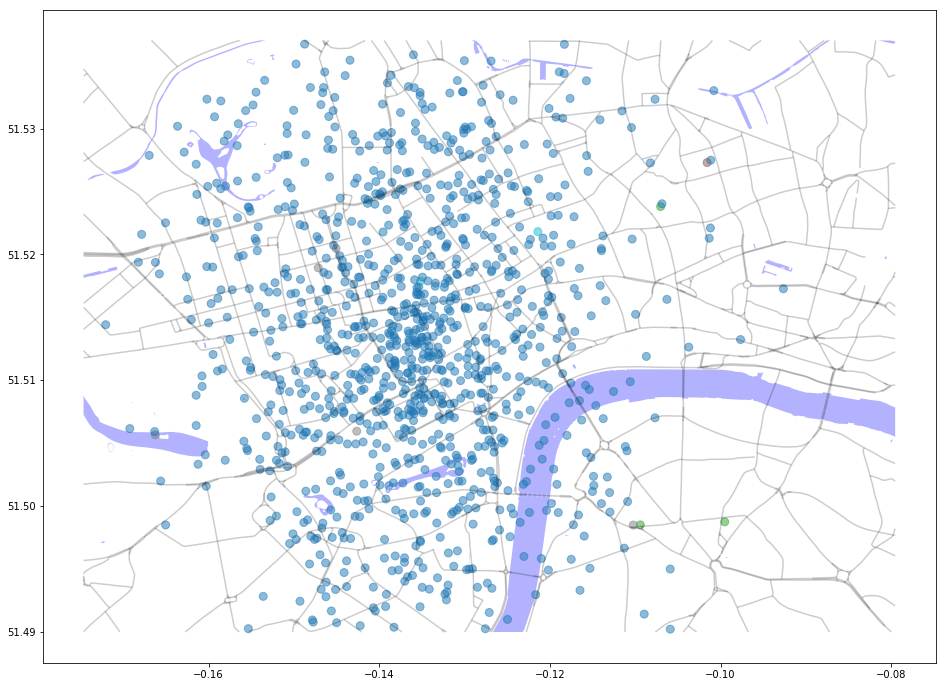

In [27]:
simulation.gather_reports_for_day_28()
plot_outbreak()